In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision import datasets, models, transforms
import torch.nn as nn

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [4]:
traindir = "dataset_splited/train"
testdir = "dataset_splited/val"

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [5]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    # делаем предсказание
    yhat = model(x)
    model.train()
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss
  return train_step

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)

for params in model.parameters():
  params.requires_grad_ = False

# добавляем последний слой сетки
nr_filters = model.fc.in_features  
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

c:\Users\Sveta\projects\binary_classification_Video\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Sveta\projects\binary_classification_Video\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

loss_fn = BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.fc.parameters()) 
train_step = make_train_step(model, optimizer, loss_fn)

In [8]:
losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 1
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): 
    x_batch , y_batch = data
    x_batch = x_batch.to(device) # gpu или cpu
    y_batch = y_batch.unsqueeze(1).float() 
    y_batch = y_batch.to(device) 


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch,epoch_loss))


  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in testloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() 
      y_batch = y_batch.to(device)

      model.eval()
      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    # сохранить лучшую модель
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break 
    
# загрузить лучшую модель
model.load_state_dict(best_model_wts)

100%|██████████| 1883/1883 [4:07:24<00:00,  7.88s/it]     



Epoch : 0, train loss : 0.04260438680648804
Epoch : 0, val loss : 0.0055692847818136215
/nTerminating: early stopping


<All keys matched successfully>

рабочее место пустует


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


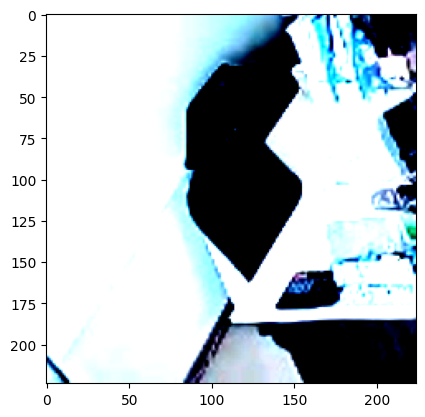

In [9]:
def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("человек на рабочим месте")
  else:
    print("рабочее место пустует")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)